In [1]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
from multiprocessing.pool import ThreadPool
from shapely.geometry import Polygon, MultiPolygon, shape

In [2]:
SAMPLE_FREQ = 3

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
import seaborn as sns
sns.set_theme()

In [5]:
ACLED_SPREADSHEET = 'Ukraine_Black_Sea_2020_2023_Mar10.xlsx'
ACLED_CSV = 'Ukraine_Black_Sea_2020_2023_Mar10.csv'

In [6]:
acled = pd.read_excel(ACLED_SPREADSHEET)

In [7]:
# acled

In [8]:
#acled.columns

Index(['ISO', 'EVENT_ID_CNTY', 'EVENT_ID_NO_CNTY', 'EVENT_DATE', 'YEAR',
       'TIME_PRECISION', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1',
       'ASSOC_ACTOR_1', 'INTER1', 'ACTOR2', 'ASSOC_ACTOR_2', 'INTER2',
       'INTERACTION', 'REGION', 'COUNTRY', 'ADMIN1', 'ADMIN2', 'ADMIN3',
       'LOCATION', 'LATITUDE', 'LONGITUDE', 'GEO_PRECISION', 'SOURCE',
       'SOURCE_SCALE', 'NOTES', 'FATALITIES', 'TIMESTAMP'],
      dtype='object')

In [10]:
acled['date'] = pd.to_datetime(acled.EVENT_DATE)

In [11]:
acled = acled.set_index('date')

In [12]:
war = acled['2022-02-24':]

In [13]:
#war.ACTOR1.value_counts().head(40)

### Extracting Russian "actors"
This is not 100% accurate but the stragglers so few they're not relevant.
Only "Unidentified Military Forces" may be skewing results a bit.

In [14]:
not_ukraine = war[~war['ACTOR1'].str.contains('Ukraine')]

In [15]:
# not_ukraine.ACTOR1.value_counts().head(40)

In [16]:
# not_ukraine.EVENT_TYPE.value_counts().head(40)

In [17]:
# not_ukraine.SUB_EVENT_TYPE.value_counts().head(40)

In [21]:
strikes = not_ukraine[not_ukraine.SUB_EVENT_TYPE == 'Air/drone strike']

In [18]:
# strikes

In [19]:
# strikes.NOTES.values

In [22]:
# Dummy var - maybe smarter to to .count() instead of summing dummy vars
strikes['dummy'] = 1

/tmp/ipykernel_9874/4090086438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strikes['dummy'] = 1


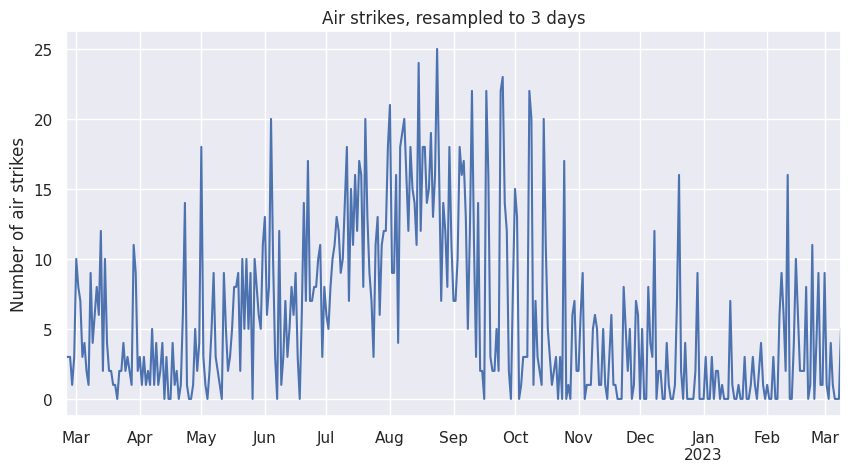

In [23]:
plt.figure()
plt.title(f'Air strikes, resampled to {SAMPLE_FREQ} days')
strikes['dummy'].resample('1d').sum().plot(xlabel='', ylabel='Number of air strikes')
plt.savefig('acled_air_strikes.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_air_strikes.png', bbox_inches='tight', dpi=600)

<AxesSubplot: xlabel='date'>

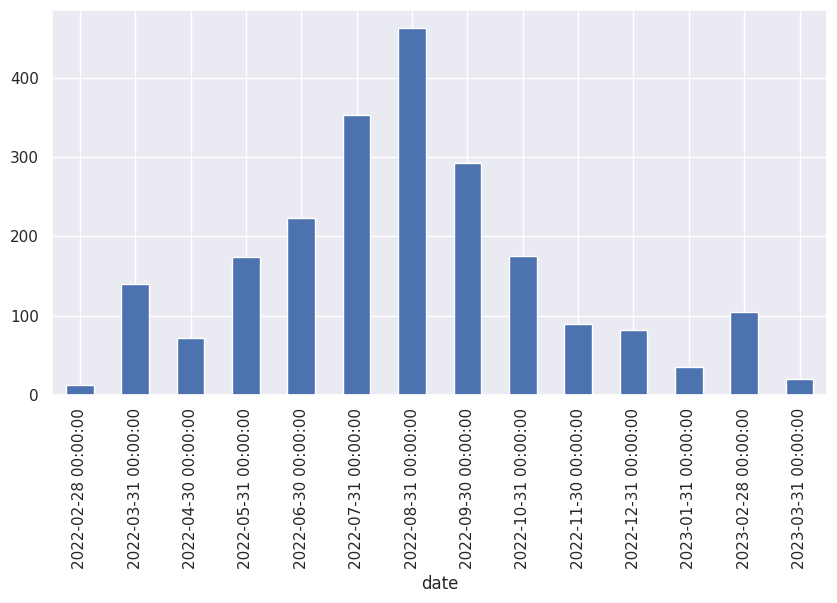

In [24]:
# Take _any_ column, they all evaluate to the same value
strikes.groupby(strikes.index).count()['ISO'].resample('M').sum().plot.bar()

In [25]:
missile_strikes = strikes[strikes['NOTES'].str.contains('missile|rocket')]

In [26]:
missile_strikes['dummy'] = 1

/tmp/ipykernel_9874/3808476491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missile_strikes['dummy'] = 1


<AxesSubplot: xlabel='date'>

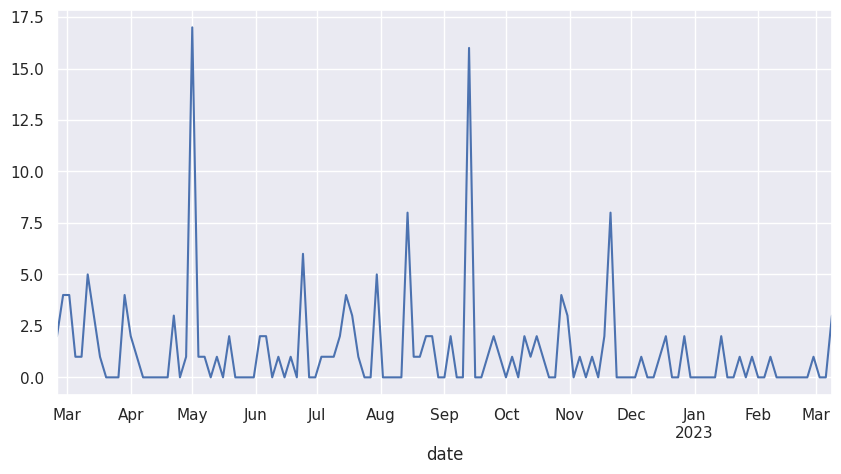

In [27]:
missile_strikes['dummy'].resample(str(SAMPLE_FREQ) + 'd').sum().plot()

In [28]:
missile_strikes['dummy'].to_csv('acled_missiles_dummy.csv')

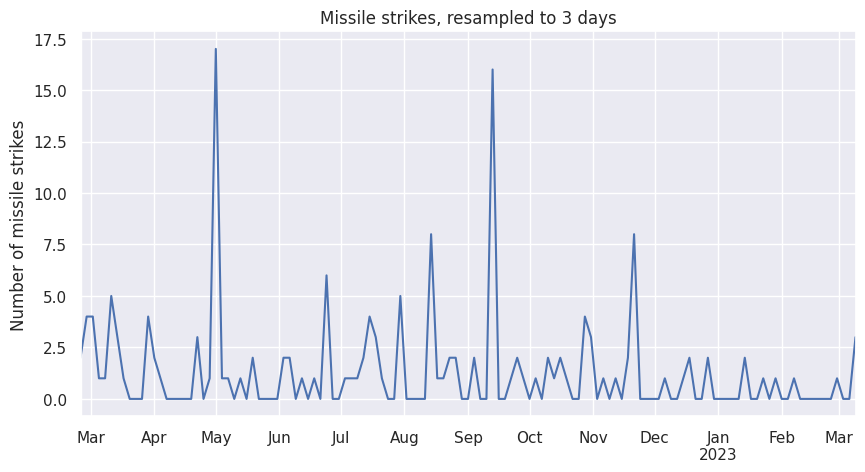

In [29]:
plt.figure()
plt.title(f'Missile strikes, resampled to {SAMPLE_FREQ} days')
missile_strikes['dummy'].resample('3d').sum().plot(xlabel='', ylabel='Number of missile strikes')
plt.savefig('acled_missile_strikes.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missile_strikes.png', bbox_inches='tight', dpi=600)

In [30]:
strikes_comparison = pd.concat(
    [missile_strikes['dummy'].resample('3d').sum(), strikes['dummy'].resample('3d').sum()],
    axis=1,
)
strikes_comparison.columns = ['missile_strikes', 'strikes']
strikes_comparison = strikes_comparison.sort_index()

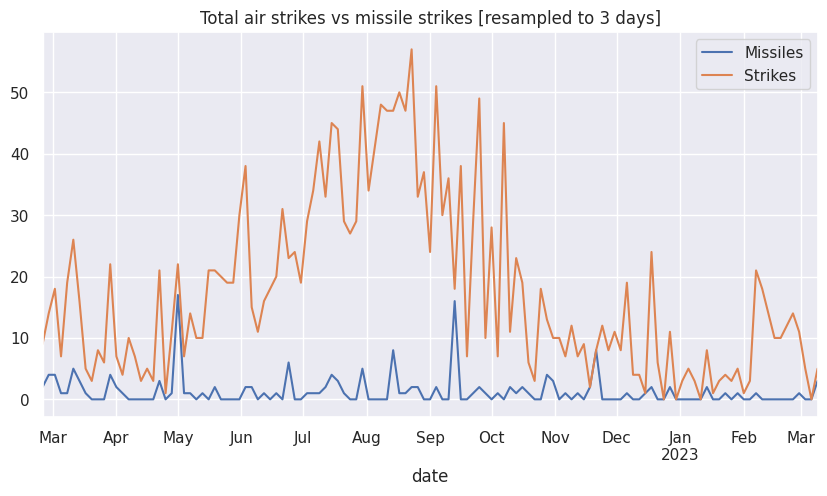

In [31]:
plt.figure()
plt.title(f'Total air strikes vs missile strikes [resampled to {SAMPLE_FREQ} days]')
#missiles['dummy'].resample('3d').sum().plot(xlabel='', ylabel='Number of strikes')
#strikes['dummy'].resample('3d').sum().plot(xlabel='')
ax = strikes_comparison['missile_strikes'].plot()
strikes_comparison['strikes'].plot(ax=ax)
ax.legend(['Missiles', 'Strikes'])

plt.savefig('acled_air_vs_missile_strikes.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_air_vs_missile_strikes.png', bbox_inches='tight', dpi=600)

## Correlation missiles to total (air) strikes

In [32]:
strikes_comparison.corr().iloc[0, 1]

0.1788722721999166

In [33]:
# strikes.SOURCE.value_counts().head(30)

# All missile strikes
Also counting missiles as part of regular battles, as they're not exclusively coded to "Air" events

In [64]:
missiles = not_ukraine[not_ukraine['NOTES'].str.contains('missile|rocket')]

In [65]:
missiles = missiles.sort_index()

<AxesSubplot: xlabel='date'>

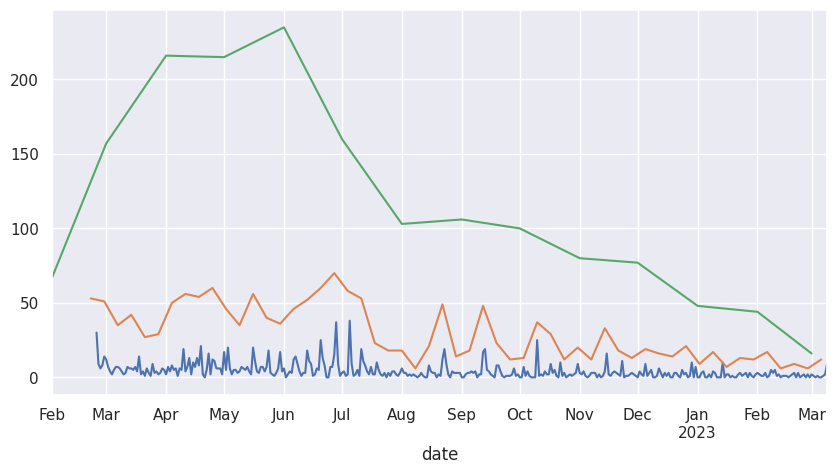

In [36]:
#missiles.resample('1d').apply({'ISO': 'count'})
#missiles.groupby(lambda x: x.date).count()
missiles['ISO'].resample('1d').count().plot()
missiles['ISO'].resample('1w').count().plot()
missiles['ISO'].resample('1m').count().plot()
plt.savefig('acled_missiles_day-week-month.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_day-week-month.png', bbox_inches='tight', dpi=600)

In [37]:
# missiles.NOTES.values[:100]

In [66]:
missile_counts = missiles['ISO'].resample('1d').count()

<AxesSubplot: xlabel='date'>

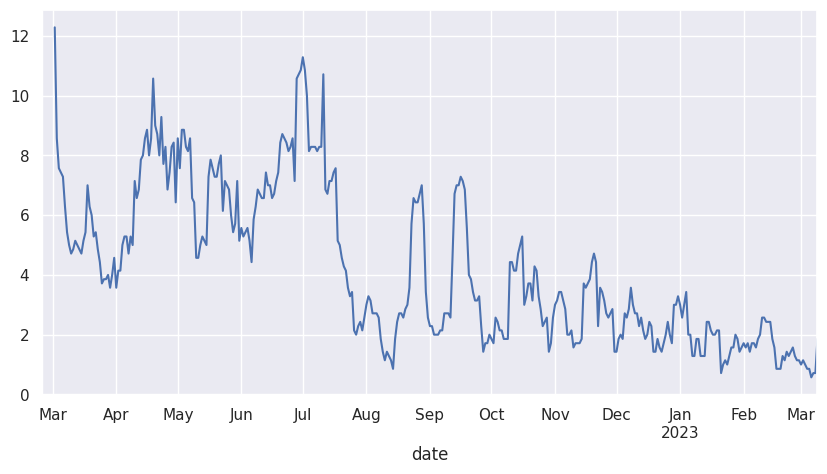

In [40]:
missile_counts.rolling(7).mean().plot()

In [67]:
analysis = pd.DataFrame(
    {'count': missiles['ISO'].resample('1d').count().values},
    index=missiles['ISO'].resample('1d').count().index,
)

In [42]:
analysis.rolling(3, min_periods=1, center=True).mean()

,count
date,
2022-02-24,19.500000
2022-02-25,15.000000
2022-02-26,7.666667
2022-02-27,9.333333
2022-02-28,11.333333
...,...
2023-03-05,0.333333
2023-03-06,0.333333
2023-03-07,1.000000


In [44]:
# analysis[analysis['count'] != 0].index

In [45]:
# analysis[analysis['count'] != 0].rolling(3, min_periods=2, center=True).apply(distance)

def dataframe_roll(df):
    def my_fn(window_series):
        return (window_series.index[-1] - window_series.index[0]).days
        # return window_series[0]
        # Note: you can do any kind of offset here
        #window_df = df[(df.index >= window_series.index[0]) & (df.index <= window_series.index[-1])]
        #print(window_df['count'].index)
        #return window_df['count'][0]
    return my_fn

<AxesSubplot: xlabel='date'>

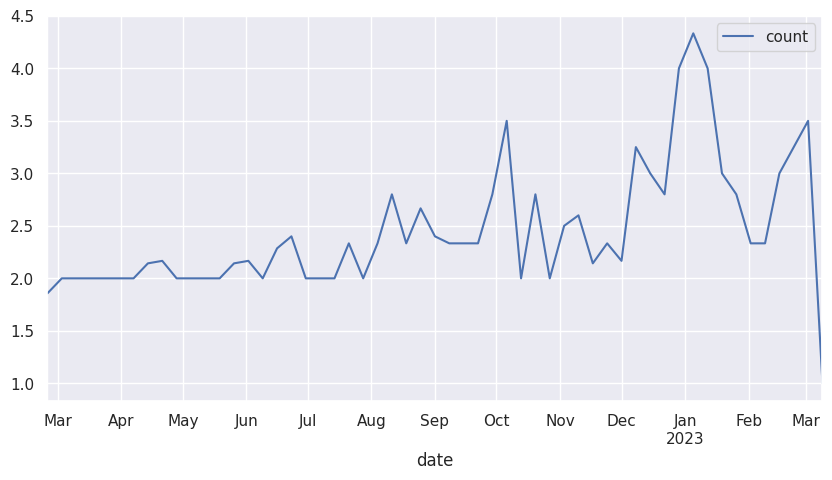

In [46]:
analysis[analysis['count'] != 0]\
    .rolling(3, min_periods=2, center=True)\
    .apply(dataframe_roll(analysis), raw=False)\
    .resample('7d').mean()\
    .plot()

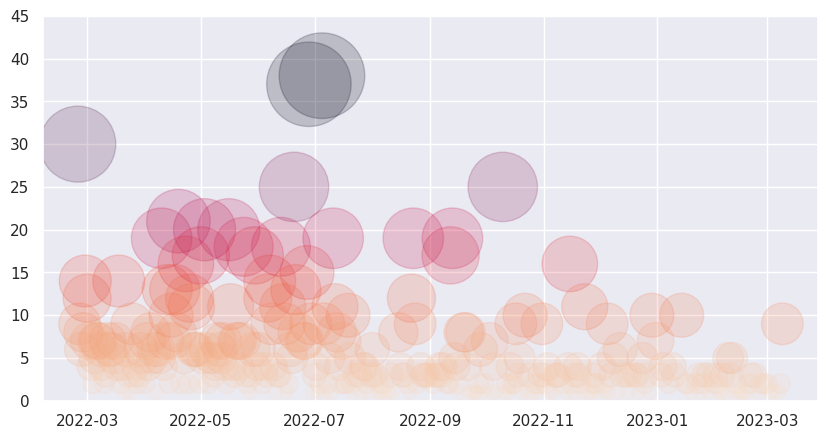

In [47]:
length = missile_counts.index.shape[0]
ax = plt.gca()
ax.set_ylim([0, 45])

plt.scatter(
    missile_counts.index,
    missile_counts, # np.zeros(length),
    s=[x*100 for x in missile_counts],
    alpha=0.2,
    c=[-x*100 for x in missile_counts], # np.random.rand(length),
)
plt.savefig('acled_missiles_scatter_2d.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_scatter_2d.png', bbox_inches='tight', dpi=600)

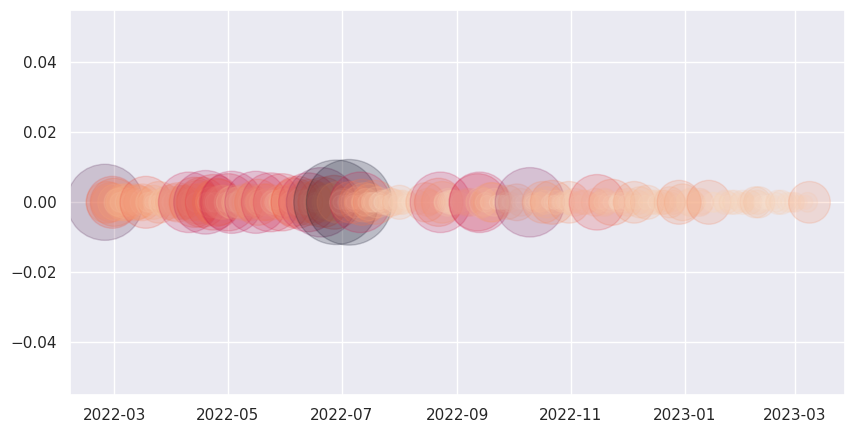

In [54]:
plt.scatter(
    missile_counts.index,
    np.zeros(length),
    s=[x*100 for x in missile_counts],
    alpha=0.2,
    c=[-x*100 for x in missile_counts], # np.random.rand(length),
)
plt.savefig('acled_missiles_scatter_1d.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_scatter_1d.png', bbox_inches='tight', dpi=600)

### Identifying missile barrages

In [68]:
# Define barrages as having at least 10 strikes a day
BARRAGE_CUTOFF = 10

analysis['barrages'] = analysis['count'].apply(lambda x: x if x > BARRAGE_CUTOFF else np.nan)

In [52]:
analysis

,count,barrages
date,,
2022-02-24,30,30.0
2022-02-25,9,NaN
2022-02-26,6,NaN
2022-02-27,8,NaN
2022-02-28,14,14.0
...,...,...
2023-03-05,0,NaN
2023-03-06,0,NaN
2023-03-07,1,NaN


<module 'matplotlib.pyplot' from '/home/me/.virtualenvs/vp/lib/python3.10/site-packages/matplotlib/pyplot.py'>

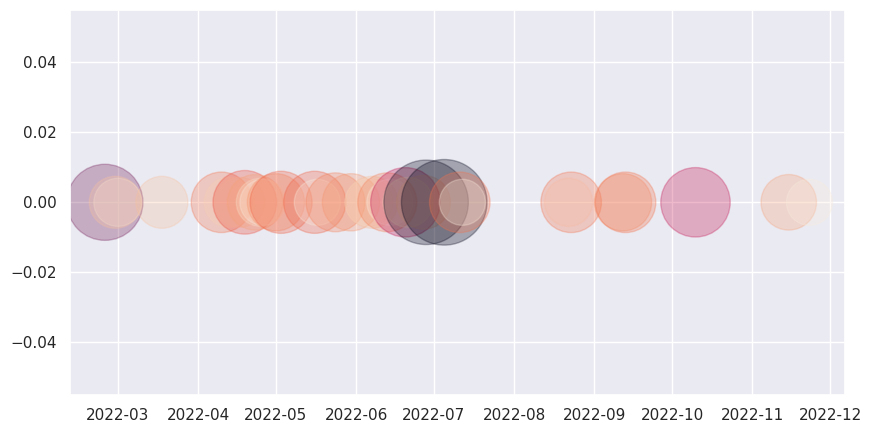

In [53]:
length = analysis['barrages'].index.shape[0]
plt.scatter(
    analysis['barrages'].index,
    np.zeros(length),
    s=[x*100 for x in analysis['barrages']],
    alpha=0.3,
    c=[-x*100 for x in analysis['barrages']], # np.random.rand(length),
)
plt.savefig('acled_missiles_barrages_scatter_1d.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_barragesscatter_1d.png', bbox_inches='tight', dpi=600)

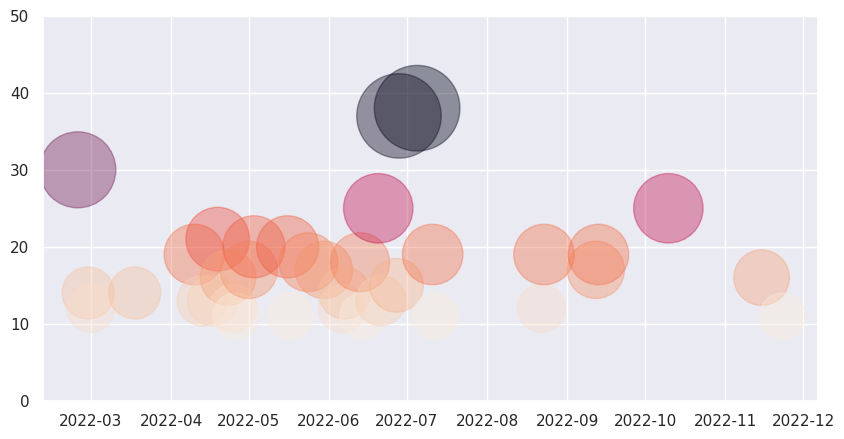

In [55]:
length = analysis['barrages'].index.shape[0]
ax = plt.gca()
ax.set_ylim([0, 50])

plt.scatter(
    analysis['barrages'].index,
    analysis['barrages'],
    s=[x*100 for x in analysis['barrages']],
    alpha=0.4,
    c=[-x*100 for x in analysis['barrages']],
)
plt.savefig('acled_missiles_barrages_scatter_2d.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_barragesscatter_2d.png', bbox_inches='tight', dpi=600)

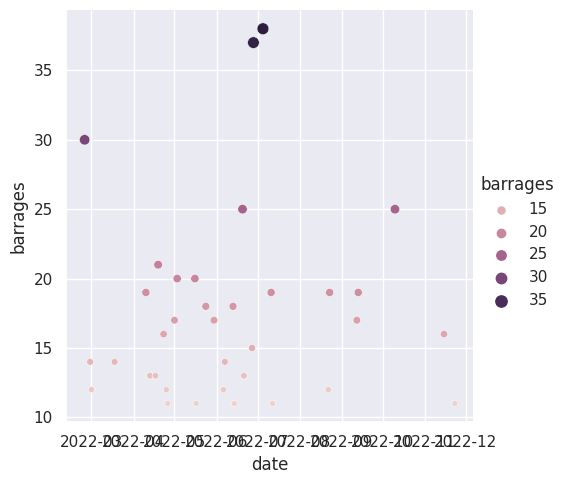

In [260]:
sns.relplot(
    data=analysis,
    x='date', y='barrages',
    hue='barrages',
    size='barrages'
)

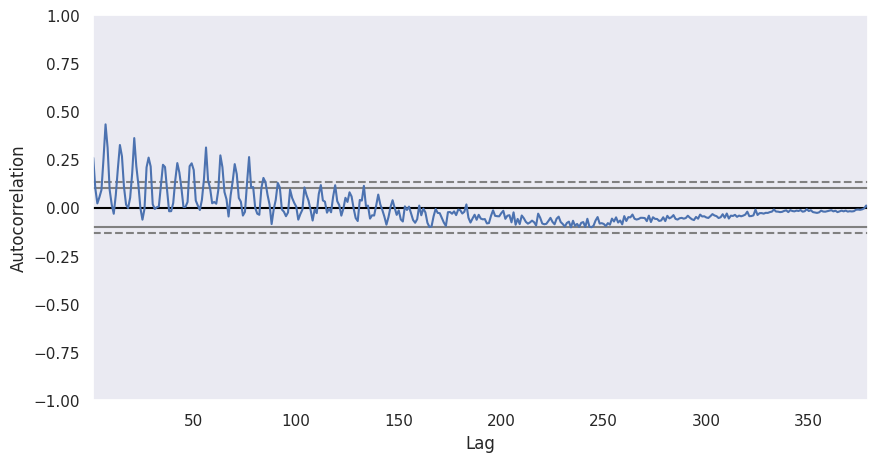

In [56]:
from pandas.plotting import autocorrelation_plot
plt.figure();
autocorrelation_plot(analysis['count'])
plt.savefig('acled_missiles_autocorrelation.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_autocorrelation.png', bbox_inches='tight', dpi=600)

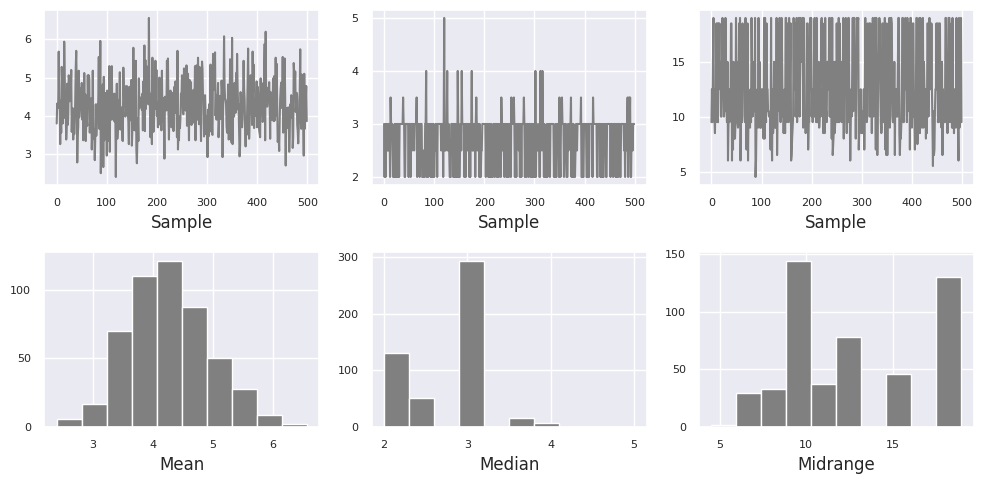

In [266]:
from pandas.plotting import bootstrap_plot
bootstrap_plot(analysis['count'], size=50, samples=500, color="grey");

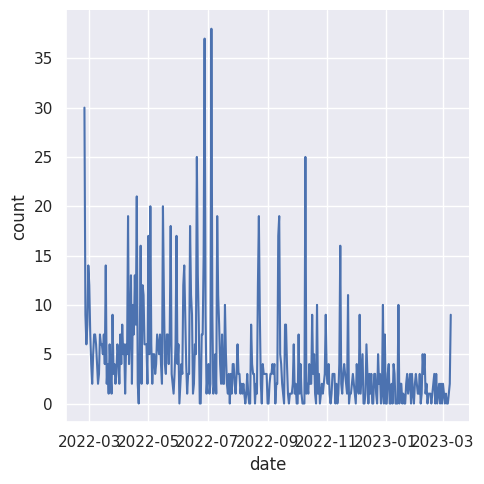

In [272]:
sns.relplot(data=analysis, x='date', y='count', kind="line", errorbar='sd')

In [69]:
analysis['date'] = analysis.index.to_pydatetime()

In [70]:
analysis['date'] = analysis['date'].apply(lambda x: int(x.timestamp()))

/tmp/ipykernel_9874/3192376083.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks_dates)


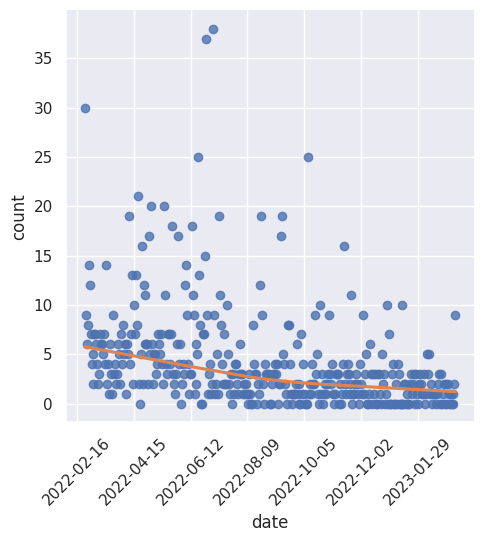

In [71]:
sns.lmplot(data=analysis, x='date', y='count', lowess=True, line_kws={"color": "C1"})

# XXX This is a hack and discouraged by seaborn authors
# https://stackoverflow.com/questions/40558128/using-datetimes-with-seaborns-regplot

ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks(rotation=45)
xticks_dates = [datetime.fromtimestamp(x).strftime('%Y-%m-%d') for x in xticks]
ax.set_xticklabels(xticks_dates)

plt.savefig('acled_missiles_reg_lowess.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_reg_lowess.png', bbox_inches='tight', dpi=600)

/tmp/ipykernel_9874/219493459.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks_dates)


[Text(1640000000.0, 0, '2021-12-20'),
 Text(1645000000.0, 0, '2022-02-16'),
 Text(1650000000.0, 0, '2022-04-15'),
 Text(1655000000.0, 0, '2022-06-12'),
 Text(1660000000.0, 0, '2022-08-09'),
 Text(1665000000.0, 0, '2022-10-05'),
 Text(1670000000.0, 0, '2022-12-02'),
 Text(1675000000.0, 0, '2023-01-29'),
 Text(1680000000.0, 0, '2023-03-28')]

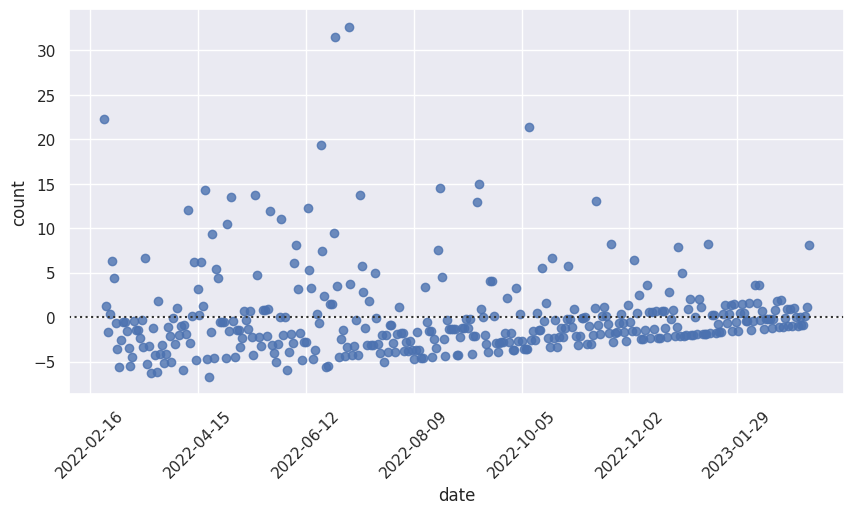

In [72]:
sns.residplot(data=analysis, x='date', y='count', line_kws={"color": "C1"})

ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks(rotation=45)
xticks_dates = [datetime.fromtimestamp(x).strftime('%Y-%m-%d') for x in xticks]
ax.set_xticklabels(xticks_dates)

In [74]:
analysis['cumulative'] = analysis['count'].cumsum()

In [320]:
analysis

,count,barrages,date,cumulative
date,,,,
2022-02-24,30,30.0,1645660800,30
2022-02-25,9,NaN,1645747200,39
2022-02-26,6,NaN,1645833600,45
2022-02-27,8,NaN,1645920000,53
2022-02-28,14,14.0,1646006400,67
...,...,...,...,...
2023-03-05,0,NaN,1677974400,1612
2023-03-06,0,NaN,1678060800,1612
2023-03-07,1,NaN,1678147200,1613


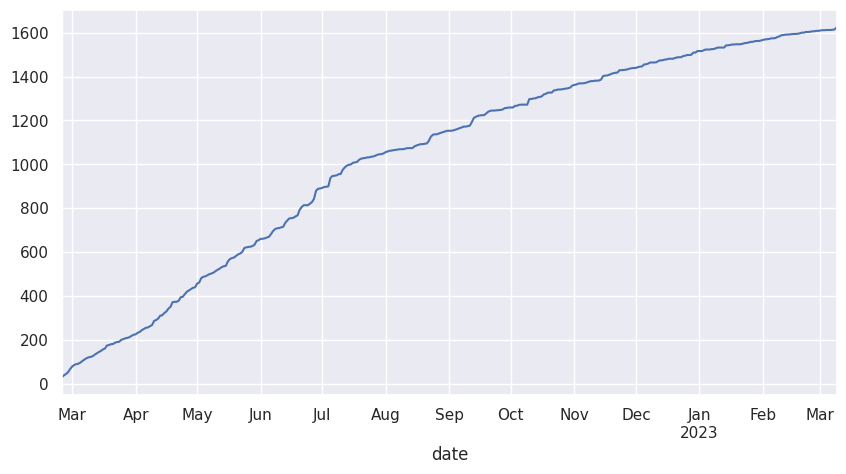

In [75]:
plt.figure()
analysis['cumulative'].plot()
plt.savefig('acled_missiles_cumulative.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_cumulative.png', bbox_inches='tight', dpi=600)

In [ ]:
sns.lmplot(data=analysis, x='date', y='cumulative', line_kws={"color": "C1"})

ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks(rotation=45)
xticks_dates = [datetime.fromtimestamp(x).strftime('%Y-%m-%d') for x in xticks]
ax.set_xticklabels(xticks_dates)

plt.savefig('acled_missiles_reg_cumulative.svg', bbox_inches='tight', dpi=600)
plt.savefig('acled_missiles_reg_cumulative.png', bbox_inches='tight', dpi=600)